# Analysis of Developmental Language Data Using Multiple Regression
![](images/Hoff_Naigles_2002_table5.png)


# Linear Relationships


One of the most basic things a researcher is interested in is seeing whether there is any relationship between variables. Here, we will look at data from Nettle (1998).

<img src="https://github.com/ethanweed/ExPsyLing/blob/master/Notebooks/Nettle_1998_abstract.png?raw=true" width="700" height="700" />



## Data

Nettle recorded:

1. the *number of languages* 
1. the *area* (in km<sup>2</sup>) 
1. the *population* 
1. the *mean growing season* (MGS, in months) 
1. the number of weather stations measuring MGS
1. the standard deviation of the measurements of MGS from the different weather stations in each country.

In [1]:
from os import chdir as cd
import pandas as pd

#pathin = '/Users/ethan/Documents/GitHub/ethanweed.github.io/python-tutorials/data/'
#file = 'nettle_1998.csv'

#cd(pathin)
url = 'https://raw.githubusercontent.com/ethanweed/ethanweed.github.io/master/python-tutorials/data/nettle_1998.csv'
df = pd.read_csv(url, sep = ';')

# make a pandas "dataframe" from the .csv file. The file uses semicolons to separate the columns.
#df = pd.read_csv(file, sep = ';')

# Nettle reports the population data in 1000's, probably to save room in the data table, 
#but that is an unusual number to think about population in, so let's convert to millions. 
#While we're at it, let's convert km2 to millions, so that the number doesn't appear in scientific notation 
#on the x-axis
df['Population'] = df['Population']*1000/1000000
df['Area'] = df['Area']/1000000

# look at the first lines of the dataframe
df.head()

,Country,Languages,Area,Population,Stations,MGS,GS_SD,Variable_GS,Used_in_1996
0,Algeria,18,2.381741,25.660,102,6.60,2.29,Y,N
1,Angola,42,1.246700,10.303,50,6.22,1.87,N,N
2,Australia,234,7.713364,17.336,134,6.00,4.17,Y,N
3,Bangladesh,37,0.143998,118.745,20,7.40,0.73,N,N
4,Benin,52,0.112622,4.889,7,7.14,0.99,N,Y



## Plotting Correlations
- We can use seaborn to see if there is any clear relationship between these variables. 

- Is there a relationship countries' *area* and their *number of languages spoken*?  

- We can use the ``sns.regplot`` function to take a quick look.

[Text(0.5, 0, 'Area (millions of km2)')]

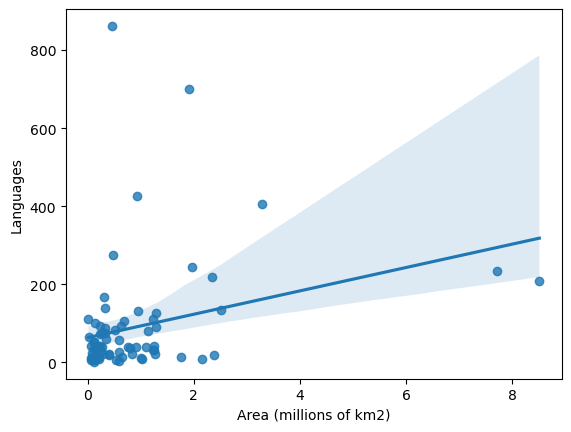

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np

sns.regplot(x = "Area", y = "Languages", data = df).set(xlabel='Area (millions of km2)')

There does seem to be some sort of relationship here, but it is difficult to see on the plot. A few countries are outliers, and they are pushing all the other data down into the lower-left corner. By transforming the data to a logarithmic scale, we can stretch them out a bit, and make them easier to see. Let's add two more columns to the dataframe, with log-transformed versions of the Population and Area data:

In [3]:
df['Population_log'] = np.log(df['Population'])
df['Area_log'] = np.log(df['Area'])
df['Languages_log'] = np.log(df['Languages'])
df.tail()

,Country,Languages,Area,Population,Stations,MGS,GS_SD,Variable_GS,Used_in_1996,Population_log,Area_log,Languages_log
69,Vietnam,88,0.331689,68.183,40,8.80,1.59,N,N,4.222195,-1.103557,4.477337
70,Yemen,6,0.527968,12.302,2,0.00,0.00,N,N,2.509762,-0.638720,1.791759
71,Zaire,219,2.344858,36.672,16,9.44,1.90,N,N,3.602014,0.852225,5.389072
72,Zambia,38,0.752618,8.780,30,5.43,0.67,N,N,2.172476,-0.284197,3.637586
73,Zimbabwe,18,0.390759,10.019,52,5.29,1.43,N,N,2.304483,-0.939664,2.890372


Now the relationship is a little easier to see:

<Axes: xlabel='Area_log', ylabel='Languages_log'>

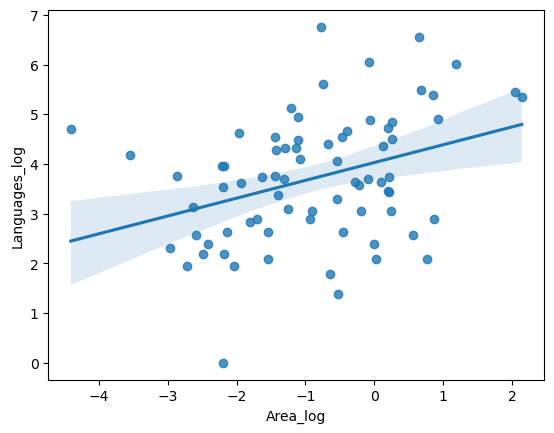

In [4]:
# Plot the log-transformed data
sns.regplot(x = "Area_log", y = "Languages_log", data = df)


Text(0, 0.5, 'Languages (log)')

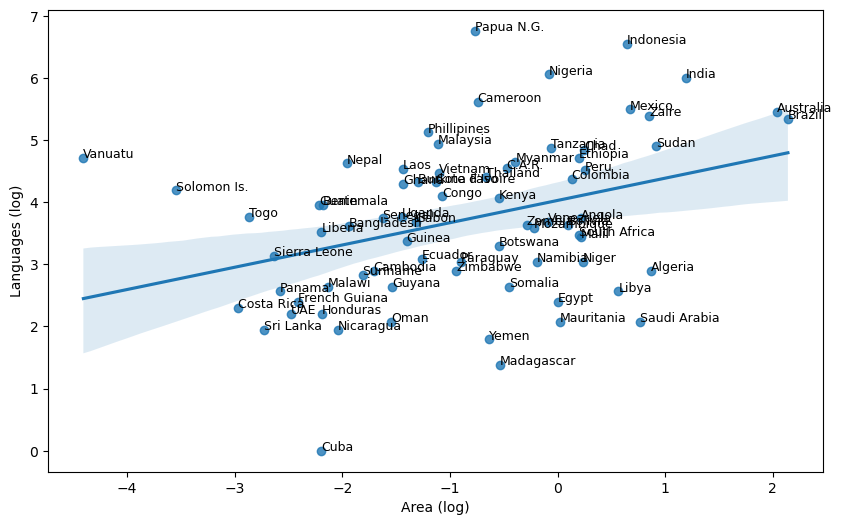

In [5]:
plt.figure(figsize=(10, 6))
sns.regplot(x="Area_log", y="Languages_log", data=df)

# Add labels for all points
for i, row in df.iterrows():
    plt.text(row['Area_log'], row['Languages_log'], row['Country'], fontsize=9)

plt.xlabel('Area (log)')
plt.ylabel('Languages (log)')


In [6]:
import pingouin as pg

pg.corr(x = df['Area'], y = df['Languages'], method = 'pearson')

,n,r,CI95%,p-val,BF10,power
pearson,74,0.290502,"[0.07, 0.49]",0.012044,3.194,0.717475


The output tells us that there is a positive correlation between the number of languages and the area of the country. We can see this in the correlation coefficient (cor) which is 0.29. The correlation coefficient is a number between 1 and -1, with 1 indicating a perfect positive correlation, and -1 indicating a perfect negative correlation. The p-value of the correlation indicates how confident we can be in the fit of the model.

## Correlation Matrix

Sometimes it can be useful to look at all the correlations between all of the variables in a dataset at once. This can be done with a correlation matrix. However, we should be careful about reading too much into a correlation matrix: it just tells us how much the variables correlate with each other. In order to be more rigorous about making predictions, we will need to build linear models.

In [7]:
print( df[['Languages','Area', 'Population', 'MGS']].corr())

            Languages      Area  Population       MGS
Languages    1.000000  0.290502    0.408753  0.241796
Area         0.290502  1.000000    0.333082 -0.127708
Population   0.408753  0.333082    1.000000 -0.017172
MGS          0.241796 -0.127708   -0.017172  1.000000


## Modelling a Relationship as a Linear Regression

In the plot above, we used a linear model to draw the line between the points. The straight line in the plot is a linear model, that minimizes the distance between the line and every individual point. 

If we generate some random numbers to create white noise, then the line should be close to horizontal. 

We can test this by generating some white noise data. Here we create a vector of 1000 random numbers between 0 and 100 plotted against 1000 other random numbers between 0 and 100:

In [8]:
from random import seed
from random import randint
seed(42)
x = []
y = []
for _ in range(1000):
    xvalue = randint(0, 100)
    yvalue = randint(0, 100)
    x.append(xvalue)
    y.append(yvalue)

df_random = pd.DataFrame(
    {'x': x,
     'y': y})     

Then we can fit a linear regression model to the data:

Text(0.5, 1.0, 'White Noise')

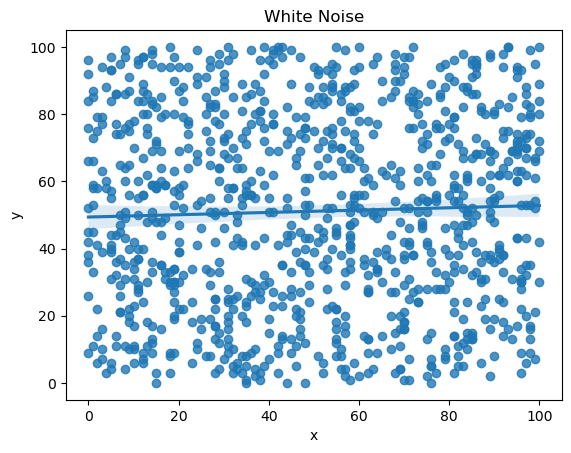

In [9]:
sns.regplot(x = "x", y = "y", data = df_random).set_title('White Noise')

If we were in doubt, our correlation matrix shows us that there is very little correlation between these two vectors of random numbers:

In [10]:
pg.corr(x = df_random['x'], y = df_random['y'], method = 'pearson')

,n,r,CI95%,p-val,BF10,power
pearson,1000,0.035471,"[-0.03, 0.1]",0.26244,0.074,0.201748


If we want to go beyond simply observing the correlation and instead use our linear model to make predictions about new data that we have not yet seen, we need to get the equation for our model's line. 

That will allow us to extend the line in either direction, and make predictions.

The equation of a line is $y=mx+y_0$, where $y_0$ is the point at which the line intercepts the y-axis. 

This is sometimes also written as $y=mx+b$, or $y=ax+b$. These equations are all equivalant. 

The important thing for our purposes is that they define the slope and intercept of a line which represents a *linear model* of the data.

Linear models are *very* useful, and they are all over the place in statistics. In the case of our random, white-noise data, because the slope is nearly equal to zero, the intercept of the model is a very close approximation of the mean of y:

Text(0.5, 1.0, 'White Noise')

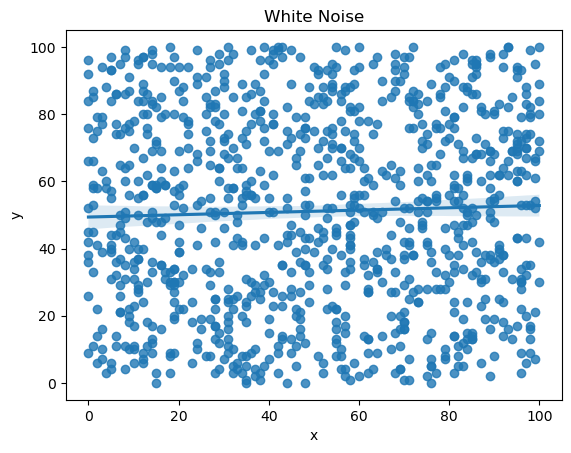

In [11]:
sns.regplot(x = "x", y = "y", data = df_random).set_title('White Noise')

In [12]:
pg.linear_regression(df_random['x'], df_random['y'])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,49.368944,1.787010,27.626570,3.072739e-125,0.001258,0.000257,45.862217,52.875671
1,x,0.034410,0.030689,1.121276,2.624402e-01,0.001258,0.000257,-0.025811,0.094632


# Modelling Number of Languages as a Linear Function of Area


In [13]:
pg.linear_regression(df['Area'], df['Languages'])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,63.370655,19.115332,3.315174,0.001437,0.084391,0.071674,25.264936,101.476373
1,Area,29.929747,11.618317,2.576083,0.012044,0.084391,0.071674,6.769055,53.090438


In the data table above we see "Area". This is the regression coefficient, or $B$ (beta). 

But Area isn't the only thing correlated with the number of languages. 

Population size looks like it might also be a relevant factor:

<Axes: xlabel='Population_log', ylabel='Languages_log'>

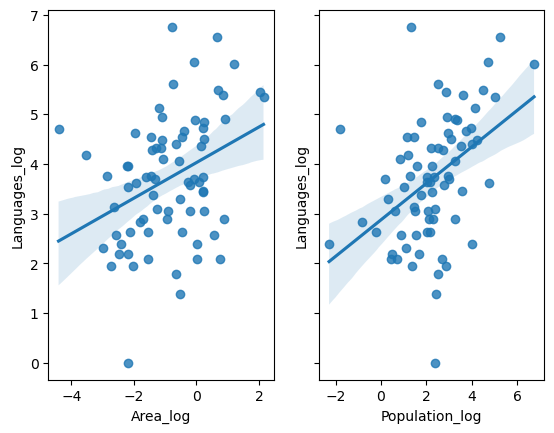

In [14]:
fig, axs = plt.subplots(ncols=2, sharey = True)
sns.regplot(x = "Area_log", y = "Languages_log", data = df, ax=axs[0])
sns.regplot(x = "Population_log", y = "Languages_log", data = df, ax=axs[1])

## Multiple Regression
By adding Population as a second *predictor variable*, we can estimate the relative importance of both Area and Population in predicting the Number of Languages:

In [15]:
pg.linear_regression(df[['Area', 'Population']], df['Languages'])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,57.289070,18.167810,3.153328,0.002366,0.193877,0.17117,21.063486,93.514654
1,Area,17.887146,11.642901,1.536314,0.128906,0.193877,0.17117,-5.328138,41.102431
2,Population,0.495039,0.159416,3.105333,0.002731,0.193877,0.17117,0.177173,0.812905


Now we can compare the $B$ values for Area and Population. 

We see that Area has a stronger relationship with Language than Population. 

On the other hand, with the introduction of the second predictor variable, Area is no longer a significant predictor. 

Finally, the two together can better account for the variance in the data (adjusted $R^2$ = 0.17) than Area alone (adjusted $R^2$ = 0.072).

![](images/Hoff_Naigles_2002_table5.png)

## Assignment 1

But what about Mean Growing Season?

Build a multiple linear regression that investigates the effect of mean growing season (which is Nettle's proxy measure for climatic variability) on the number of languages? In your regression, control for the effects of population.

In [20]:
# Multiple linear regression, predicting number of languages while controlling for population
pg.linear_regression(df[['Population', 'MGS' ]], df['Languages'])


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-10.345979,37.247795,-0.277761,0.782003,0.229007,0.207289,-84.615974,63.924015
1,Population,0.582644,0.147023,3.962951,0.000174,0.229007,0.207289,0.289489,0.875799
2,MGS,11.443454,4.791943,2.388061,0.019600,0.229007,0.207289,1.888591,20.998316


In [21]:
# Multiple linear regression, predicting number of languages while controlling for population and area
pg.linear_regression(df[['Population', 'Area', 'MGS' ]], df['Languages'])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-34.525905,38.634386,-0.893657,0.374567,0.268038,0.236668,-111.579759,42.527948
1,Population,0.483984,0.153044,3.162396,0.002314,0.268038,0.236668,0.178749,0.789220
2,Area,21.770077,11.268126,1.932005,0.057407,0.268038,0.236668,-0.703490,44.243645
3,MGS,12.628959,4.742173,2.663116,0.009599,0.268038,0.236668,3.170993,22.086925


MGS is a significant predictor of language diversity, even when controlling for population and area. Notice that $B$ values (coef) and $p$ values change depending on how many predictors there are in the model, but the overall contribution of MGS as a predictor remains around the same.

## Assignment 2

In 2002, Hoff and Naigles measured factors that they hypothesized could affect language development. They video-taped children age 18-29 months, and transcribed teh videos. They recorded the number of word types, and the mean length of utterance (MLU), for both the children and the parents (Input). They used a multiple linear regression to investigate the relative contribution of each of these factors to the vocabulary (as measured by word types) 10 weeks later.  

Look at the results of the regression in Table 5. 

1. Which of the measured variables significantly predicted children's vocabulary (word types) at the second visit (Time 2)?
2. Of the significant predictors, what was the _best_ predictor of improvement in children's vocabulary?
3. Did parents who spoke in longer utterances have children with a larger vocabulary 10 weeks later?
4. What was a more important factor in children's vocabulary development: the complexity of parents' languge (MLU) or the number of different words parents used in front of their children?


<img src="https://github.com/ethanweed/ExPsyLing/blob/master/Notebooks/Hoff-Naigles.png?raw=true" />


Answers:

1. Which of the measured variables significantly predicted children's vocabulary (word types) at the second visit (Time 2)?

Child word types at Visit 1, child MLU at Visit 2, and parent (input) MLU were all significant predictors of child word types at Visit 2.

2. Of the significant predictors, what was the _best_ predictor of improvement in children's vocabulary?

This is a hierarchical regression model, which is to say that predictors are added one at a time, and then the researchers looked at the _change_ in the amount of variance accounted for by the model as each predictor was added ($\Delta R^2$). Child MLU at Visit 2 has the largest $\Delta R^2$, that is to say, adding this predictor made the biggest difference in terms of how much variance in the Child Types at Visit 2 data the model could account for. Presumably this means that children who speaker in longer, more complex utterances (greater MLU) also tend to be the children who have larger vocabularies, which makes a fair amount of intuitive sense, I think.

3. Did parents who spoke in longer utterances have children with a larger vocabulary 10 weeks later?

Yes, they did. Input (presumably mostly from parents) MLU was also a significant predictor of Child Types at Visit 2, even when controlling for the child's overall linguistic ability (Child word types at Visit 1, Child MLU at Visit 2, and Input types). Adding Input MLU to the model still (significantly, $p < 0.01$) accounted for an additional 3% of the variance in Child Word Types at Visit 2, even taking all the other factors into account.

4. What was a more important factor in children's vocabulary development: the complexity of parents' languge (MLU) or the number of different words parents used in front of their children?

Interestingly, the results in this table suggest that while using a wider variety of words around and with your child is probably good for increasing their vocabulary, what is even _more_ useful is to speak in longer, more complex utterances. Hoff and Naigles (2002) point out that this contradicts the idea that we should "dumb down" our language too much when talking to young children: simpler is not necessarily better. Furthermore, they suggest that the reason longer, more complex parental utterances might help children aquire more vocabulary is that they provide a more structured linguistic scaffolding, so that when a new word is introduced, it is easier for children to integrate it into their vocabulary.